In [1]:
library(DESeq2)
library(edgeR)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The follo

## **Data Loading**

In [9]:
# loading pseudo-bulk file from python 
pb <- read.csv("pseudobulk_matrix.csv")
meta <- read.csv("meta_matrix.csv")

## **Defining counts and phenotype (meta)**

In [10]:

# Séparer l’expression et les métadonnées
counts <- pb[, !(colnames(pb) %in% 
                   c("class", "donor_id", "disease", "sex"))]
counts <- t(as.matrix(counts))
# rownames(expr) <- paste(pb$class, pb$donor_id, pb$disease, sep="_")

meta <- data.frame(
  class = pb$class,
  donor = pb$donor_id,
  disease = factor(pb$disease,levels = c("dementia || Alzheimer disease", "dementia || Parkinson disease" ,"normal")),
  sex = pb$sex
)


In [11]:
head(counts)

ENSG00000000003,71,63,110,19,60,30,104,131,52,54,⋯,1,30,0,17,13,5,0,10,8,1
ENSG00000000005,7,1,12,3,6,4,2,3,3,2,⋯,0,3,0,0,0,0,0,0,1,0
ENSG00000000419,242,258,140,154,245,107,229,257,58,76,⋯,134,1038,155,907,927,293,15,319,808,55
ENSG00000000457,173,197,102,112,156,73,146,183,29,54,⋯,85,745,146,335,605,204,11,213,516,38
ENSG00000000460,139,123,101,69,106,56,144,65,36,66,⋯,78,820,203,577,625,266,15,165,642,35
ENSG00000000938,1,2,1,1,2,2,4,4,1,3,⋯,2,4,2,4,9,6,0,4,5,0


In [12]:
# checking for the dimensions
cat("genes:", nrow(counts), "\n")
cat("samples:", ncol(counts), "\n")
cat("meta rows:", nrow(meta), "\n")

genes: 34167 
samples: 136 
meta rows: 136 


## **edgeR**

code for the edgeR

In [14]:
for (ct in unique(meta$class)) {
  idx <- meta$class == ct
  cts  <- counts[, idx, drop = FALSE]
  pheno <- meta[idx, , drop = FALSE]


  ### PART 1 : edgeR
  y <- DGEList(counts = cts, samples = pheno) 

  # 1. Normalization (TMM = Trimmed Mean of M-values)
  y <- calcNormFactors(y, method = "TMM")

  # 2. Creation of the design matrix
  design <- model.matrix(~ 0 + disease + sex, data = pheno)
  colnames(design)[1:3] <- c("AD", "PD", "CTRL") # in the same order than in meta

  # 3. filtrer the low-expressed genes 
  #(deletes the genes with a lot of zeros, reduces the noise, enhance statistical power)
  keep <- filterByExpr(y, design = design)
  y <- y[keep, , keep.lib.sizes = FALSE]


  # 4. Estimations of the 3 dispersions 
  # shared dispersion (global), trended dispersion (dep of expression levels), tagwise dispersion (per gene)
  y <- estimateDisp(y, design)

  #5. Fit of the GLM model (QLF)
  fit <- glmQLFit(y, design)

  ### PART 2 : multiple comparisons
  cont <- makeContrasts(
    AD_vs_CTRL = AD - CTRL,
    PD_vs_CTRL = PD - CTRL,
    AD_vs_PD   = AD - PD,
    levels = design
  )

  ### PART 3 : make and save the comparisons
  for (cn in colnames(cont)) {

    qlf <- glmQLFTest(fit, contrast = cont[,cn])
    tab <- topTags(qlf, n = Inf)$table

    out <- paste0("edgeR_results/edgeR_", ct, "_", cn, ".csv")
    write.csv(tab, file = out, row.names = TRUE)
  }
}

visualization of 1 file

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000224445,-3.332923,3.201687,20.18698,0.0001456244,0.9899694
ENSG00000286251,-2.841352,2.608657,18.13103,0.0002430557,0.9899694
ENSG00000126838,-3.251837,3.120778,17.98941,0.0002655522,0.9899694
ENSG00000257252,-1.593996,3.462496,17.46406,0.0004657406,0.9899694
ENSG00000259543,-1.158222,3.820907,17.99442,0.0004721311,0.9899694
ENSG00000253184,4.862826,4.864369,16.45253,0.0005243205,0.9899694


[1] 111

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9900  0.9900  0.9900  0.9922  0.9947  1.0000 

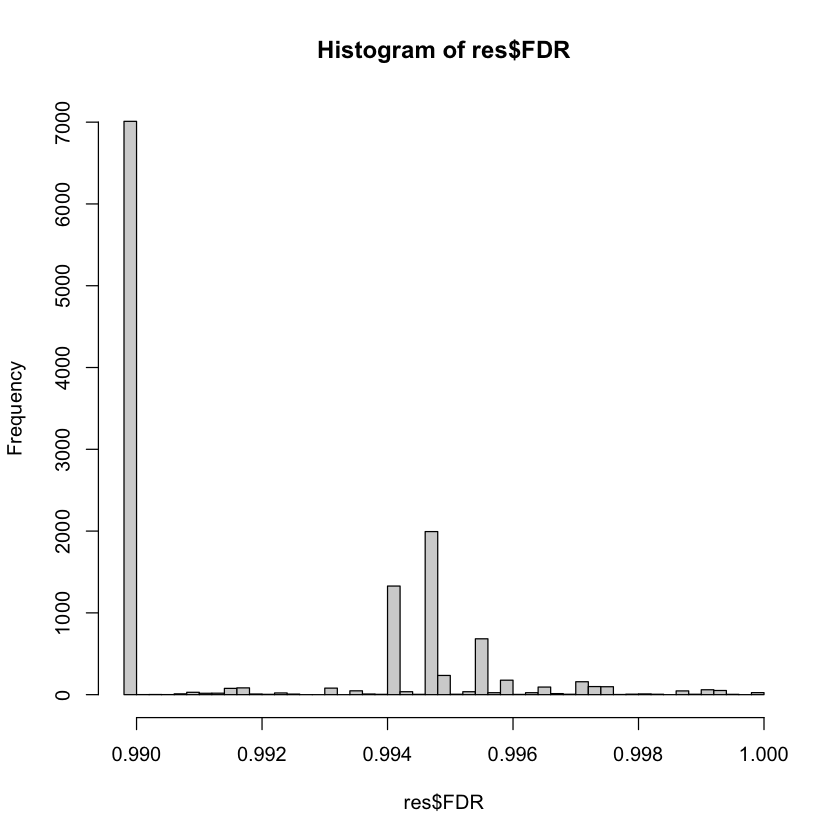

In [ ]:
res <- read.csv("edgeR_results/edgeR_Immune_AD_vs_CTRL.csv", row.names = 1)
head(res)
length(unique(res$FDR)) 
summary(res$FDR)
hist(res$FDR, breaks = 50)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000227674,5.073583,2.895816,16.57671,0.0005957600,0.9718106
ENSG00000287460,4.709925,2.048732,15.46126,0.0008474137,0.9718106
ENSG00000171680,-1.879715,4.925471,15.75400,0.0010211526,0.9718106
ENSG00000131791,1.389454,3.956780,15.44805,0.0011251052,0.9718106
ENSG00000188315,-1.312369,4.517227,15.29062,0.0011530899,0.9718106
ENSG00000138771,3.650674,4.745568,14.33827,0.0012479078,0.9718106


[1] 267

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9718  0.9718  0.9839  0.9825  0.9916  1.0000 

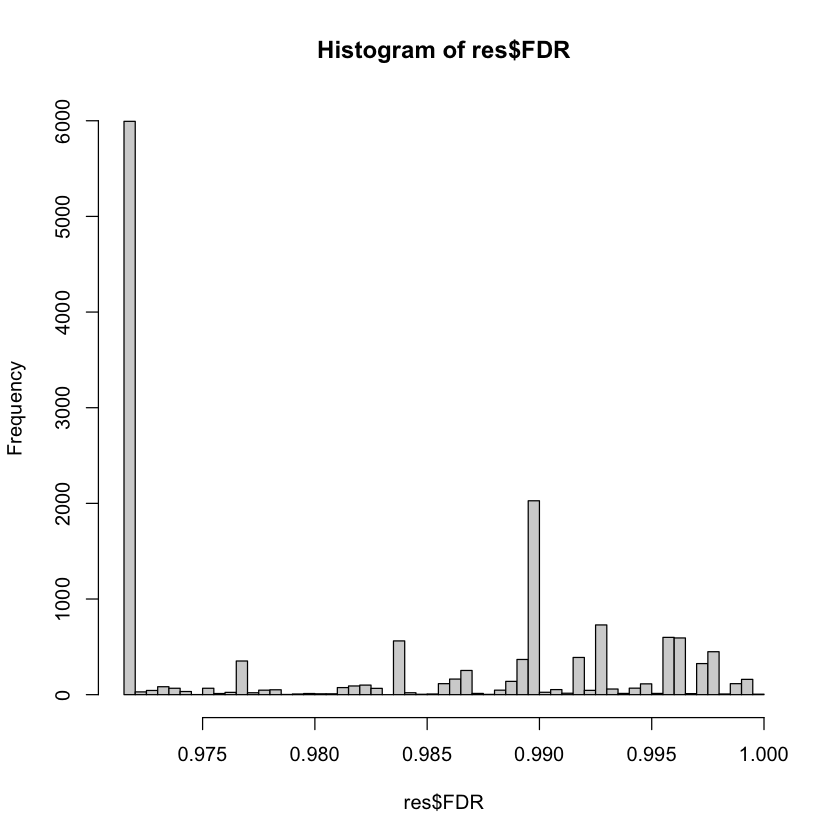

In [ ]:
res <- read.csv("edgeR_results/edgeR_Immune_AD_vs_CTRL.csv", row.names = 1)
head(res)
length(unique(res$FDR)) 
summary(res$FDR)
hist(res$FDR, breaks = 50)

format : 

y$counts     = matrix (genes × samples)

y$samples    = data.frame (samples × covariates)

## **DESes2** 

maybe need to re-run the defining counts and meta

In [8]:
for (ct in unique(meta$class)) {
  
  cat("\n=== Cell type :", ct, "===\n")
  
  idx <- meta$class == ct
  cts <- counts[idx, ]
  cts <- t(cts)  # DESeq2 = gènes × samples
  
  pheno <- meta[idx, ]
  
  # Vérifier au moins 2 conditions
  if (length(unique(pheno$disease)) < 2) {
    cat("Skip :", ct, "(not enough conditions)\n")
    next
  }
  
  # Création DESeq2
  dds <- DESeqDataSetFromMatrix(
    countData = cts,
    colData = pheno,
    design = ~ disease
  )
  
  dds <- DESeq(dds)
  
  ### --- 1) AD vs CTRL ---
  if (all(c("normal", "dementia || Alzheimer disease") %in% pheno$disease)) {
    
    res_ADvsCTRL <- results(
      dds,
      contrast = c("disease",
                   "dementia || Alzheimer disease",
                   "normal")
    )
    
    fname <- paste0("DESeq2_results/DE_", gsub("/", "_", ct), "_ADvsCTRL.csv")
    write.csv(as.data.frame(res_ADvsCTRL), fname)
    cat("Saved:", fname, "\n")
  }
  
  ### --- 2) PD vs CTRL ---
  if (all(c("normal", "dementia || Parkinson disease") %in% pheno$disease)) {
    
    res_PDvsCTRL <- results(
      dds,
      contrast = c("disease",
                   "dementia || Parkinson disease",
                   "normal")
    )
    
    fname <- paste0("DESeq2_results/DE_", gsub("/", "_", ct), "_PDvsCTRL.csv")
    write.csv(as.data.frame(res_PDvsCTRL), fname)
    cat("Saved:", fname, "\n")
  }
  
  ### --- 3) AD vs PD ---
  if (all(c("dementia || Alzheimer disease", 
            "dementia || Parkinson disease") %in% pheno$disease)) {
    
    res_ADvsPD <- results(
      dds,
      contrast = c("disease",
                   "dementia || Alzheimer disease",
                   "dementia || Parkinson disease")
    )
    
    fname <- paste0("DESeq2_results/DE_", gsub("/", "_", ct), "_ADvsPD.csv")
    write.csv(as.data.frame(res_ADvsPD), fname)
    cat("Saved:", fname, "\n")
  }
}


=== Cell type : Astro ===


ERROR: Error in DESeqDataSetFromMatrix(countData = cts, colData = pheno, design = ~disease): ncol(countData) == nrow(colData) is not TRUE


vizualisation of one file

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,7.618874,-0.235953345,0.5166267,-0.456719212,0.6478729,1
ENSG00000000005,1.277961,1.064173276,1.4979016,0.710442705,0.4774296,1
ENSG00000000419,210.721631,0.001008416,0.1612832,0.006252452,0.9950113,1
ENSG00000000457,113.876740,-0.272815484,0.1785876,-1.527628723,0.1266047,1
ENSG00000000460,96.303641,0.127990125,0.2969305,0.431044015,0.6664364,1
ENSG00000000938,1.624470,-0.200112617,1.1556028,-0.173167299,0.8625199,1


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
0.000011 1.000000 1.000000 0.999821 1.000000 1.000000      161 

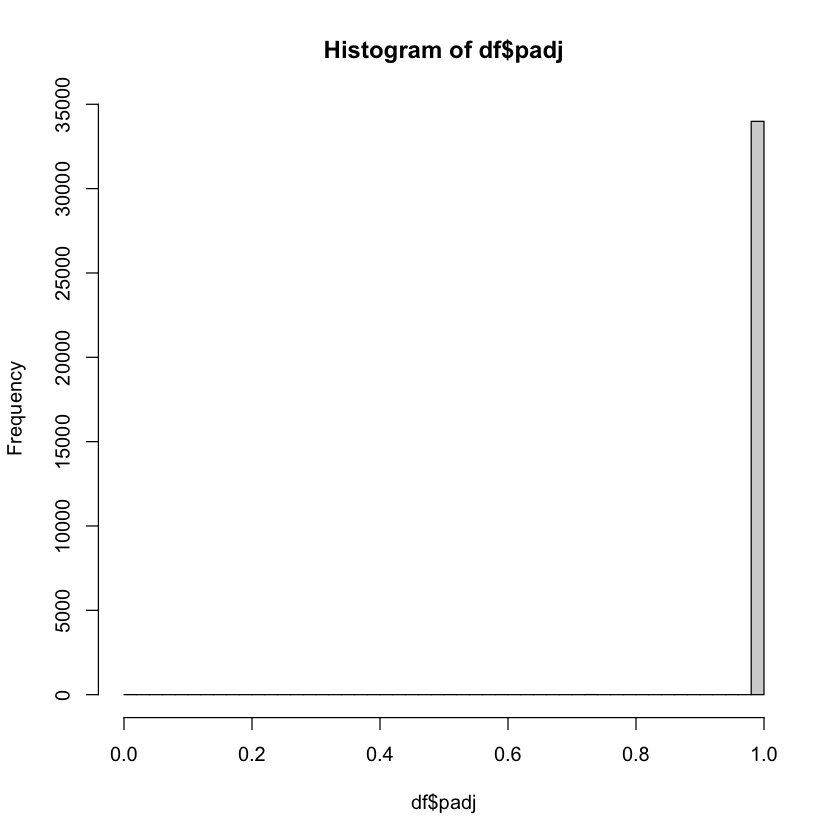

In [ ]:
df <- read.csv("DESeq2_results/DE_IN_ADvsPD.csv", row.names = 1)
head(df)
summary(df$padj)
hist(df$padj, breaks = 50)